# DCGAN (Deep Convolutional GAN)

출처 : https://github.com/eriklindernoren/Keras-GAN/blob/master/dcgan/dcgan.py

(실행시 모든 cell을 하나로 합쳐서 실행해야 함)

In [2]:
from __future__ import print_function, division

from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam

import matplotlib.pyplot as plt

import sys

import numpy as np

### 1. 파라미터 설정, model build와 compile

In [2]:
class DCGAN():
    def __init__(self):
        # input shape 설정. (mnist 이미지 크기)
        self.img_rows = 28
        self.img_cols = 28
        self.channels = 1
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        # 노이즈의 dimension
        self.latent_dim = 100

        optimizer = Adam(0.0002, 0.5)

        # discriminator 모델 생성과 컴파일(loss함수와 optimizer 설정, accaracy 측정)
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy',
            optimizer=optimizer,
            metrics=['accuracy'])

        # generator 모델 생성
        self.generator = self.build_generator()

        # generator에 들어가는 noise 텐서 만들고, generator에 넣어서 이미지 생성
        z = Input(shape=(self.latent_dim,))
        img = self.generator(z)

        # 모델을 합쳐서 학습하기 때문에 발란스 때문에 discriminator는 학습을 꺼둠. 우리는 generator만 학습
        self.discriminator.trainable = False

        # discriminator에 이미지를 입력으로 넣어서 진짜이미지인지 가짜이미지인지 판별
        valid = self.discriminator(img)

        # generator와 discriminator 모델 합침. (노이즈가 인풋으로 들어가서 판별결과가 아웃풋으로 나오게)
        # discriminator를 속이도록 generator를 학습
        self.combined = Model(z, valid)
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)

### 2. Generator 모델 구성

DCGAN Generator의 특성 : 
 - BatchNormalization이 들어감(output 제외)
 - Fully connected hidden layers 없음
 - Pooling layers 없음
 - ReLU activation function 사용
 - output 나오는 activation function은 tanh

In [2]:
    def build_generator(self):

        model = Sequential()

        model.add(Dense(128 * 7 * 7, activation="relu", input_dim=self.latent_dim))
        model.add(Reshape((7, 7, 128)))
        model.add(UpSampling2D())
        model.add(Conv2D(128, kernel_size=3, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Activation("relu"))
        model.add(UpSampling2D())
        model.add(Conv2D(64, kernel_size=3, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Activation("relu"))
        model.add(Conv2D(self.channels, kernel_size=3, padding="same"))
        model.add(Activation("tanh"))

        model.summary()
        
        # 노이즈 들어가는 텐서 생성, 노이즈를 모델에 넣고 이미지 생성
        noise = Input(shape=(self.latent_dim,))
        img = model(noise)

        return Model(noise, img)

### 3. Discriminator 모델 구성

DCGAN discriminator의 특성 : 
 - BatchNormalization이 들어감(input 제외)
 - Pooling layers 없음
 - LeakyReLU activation function 사용
 - output은 sigmoid를 거쳐 0에서 1 사이값으로 나옴. 1에 가까우면 진짜이미지, 0에 가까우면 가짜이미지

In [2]:
    def build_discriminator(self):

        model = Sequential()

        model.add(Conv2D(32, kernel_size=3, strides=2, input_shape=self.img_shape, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))
        model.add(ZeroPadding2D(padding=((0,1),(0,1))))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Conv2D(256, kernel_size=3, strides=1, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Flatten())
        model.add(Dense(1, activation='sigmoid'))

        model.summary()
        
        # 이미지를 model에 넣어서 판별함
        img = Input(shape=self.img_shape)
        validity = model(img)

        return Model(img, validity)

### 4. 학습 및 실행

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 14, 14, 32)        320       
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 7, 7, 64)          18496     
_________________________________________________________________
zero_padding2d_2 (ZeroPaddin (None, 8, 8, 64)          0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 8, 8, 64)          256       
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 8, 8, 64)          0         
__________

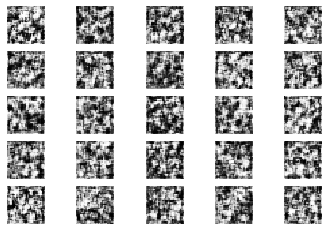

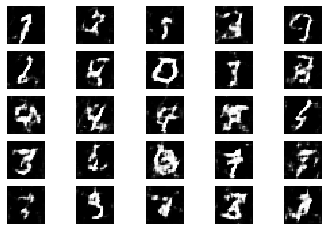

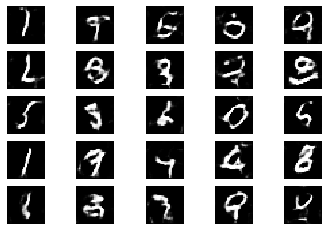

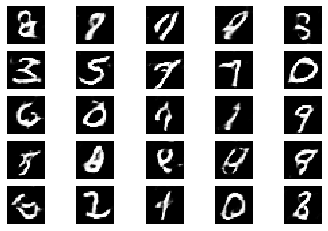

In [2]:
    def train(self, epochs, batch_size=128, save_interval=50):

        # mnist 데이터 셋 불러옴 (이미지만으로 학습하기 때문에 y값 필요없음)
        (X_train, _), (_, _) = mnist.load_data()

        # 이미지 전처리(Rescale -1 to 1), input shape(60000, 28, 28, 1)로 확장
        X_train = X_train / 127.5 - 1.
        X_train = np.expand_dims(X_train, axis=3)

        # 정답으로 제시되는 매트릭스. valid는 1, fake는 0
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))

        for epoch in range(epochs):

            # ---------------------
            #  Train Discriminator
            # ---------------------

            # batch_size만큼 이미지를 랜덤으로 뽑음
            idx = np.random.randint(0, X_train.shape[0], batch_size)
            imgs = X_train[idx]

            # Sample noise 생성(batch_size만큼), noise를 generator에 넣어서 이미지 생성
            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))
            gen_imgs = self.generator.predict(noise)

            # discriminator를 학습함. 진짜 이미지는 1이 나오게, 가짜 이미지는 0이 나오게
            # discriminator가 이미지를 판별한 값과 valid와 fake가 각각 같이 들어가서 binary_crossentropy으로 계산되어 업데이트함.
            d_loss_real = self.discriminator.train_on_batch(imgs, valid)
            d_loss_fake = self.discriminator.train_on_batch(gen_imgs, fake)
            # real을 넣었을 때와 fake를 넣었을 때의 discriminator의 loss값과 accracy값의 평균을 구함
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            # ---------------------
            #  Train Generator
            # ---------------------

            # generator를 학습함. noise를 넣고 generator가 생성한 이미지가 discriminator가 1이라고 판별할 수 있도록.
            g_loss = self.combined.train_on_batch(noise, valid)

            # 200 epoch마다 loss와 accracy 프린트
            if epoch % 200 == 0:
                print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))

            # save_interval(1000)마다 generator가 만든 이미지 프린트
            if epoch % save_interval == 0:
                self.save_imgs(epoch)

    # 이미지 출력
    def save_imgs(self, epoch):
        r, c = 5, 5
        noise = np.random.normal(0, 1, (r * c, self.latent_dim))
        gen_imgs = self.generator.predict(noise)

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5

        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
                axs[i,j].axis('off')
                cnt += 1
#         fig.savefig("images/mnist_%d.png" % epoch)
#         plt.close()


# DCGAN 실행. epochs 4000번
if __name__ == '__main__':
    dcgan = DCGAN()
    dcgan.train(epochs=4000, batch_size=32, save_interval=1000)